## Example ODE with custom library

In this notebook we provide a simple example of the DeepMoD algorithm by applying it on the a non-linear ODE

We start by importing the required DeepMoD functions:

In [1]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD functions


from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.model.func_approx import NN
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold, PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from scipy.io import loadmat


import torch
from torch.autograd import grad
from itertools import combinations
from functools import reduce
from typing import Tuple
from deepymod.utils.types import TensorList
from deepymod import Library

from scipy.integrate import odeint

# Settings for reproducibility
np.random.seed(40)
torch.manual_seed(0)

# Configuring GPU or CPU
if False: #torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cpu


We check where the package is located

In [28]:
import deepymod as dpm
dpm

<module 'deepymod' from '/net/nfs/ssd1/gmiloshe/DeePyMoD/src/deepymod/__init__.py'>

# Preparing the dataset
Firstly we prepare the dataset. The set of ODEs we consider here are
$d[y, z]/dt = [z, -z+ 5 \sin y]$

In [2]:
def dU_dt_sin(U, t):
    """
    returns the right hand side of the differential equation"""
    return [U[1], -1*U[1] + 5*np.sin(U[0])]

We then define a function that solves the ODE and then ensures that 
both coordinates and data get a shape of n_samples x feature and
be returned as (coordinate, data)

In [3]:
def create_data(U0=np.array([.75, 1]), ts=np.linspace(0, 5, 100)):
    """
    Creates data which is the solution of the simple ODE system example.
    
    Args: 
        U0: Initial condition
        ts: Time points to evaluate the ODE at.
    """
    Y = torch.from_numpy(odeint(dU_dt_sin, U0, ts)).float()
    T = torch.from_numpy(ts.reshape(-1, 1)).float()
    return T, Y

# Unnormalized and unsampled preview
We can now plot the solutions of the equations without sampling
and normalization, to show how the dataset can preprocess the data
in these common use cases.

In [4]:
# see deepymod.data.base.Dataset for definition of `Dataset` class.
dataset = Dataset(
    create_data, #load_function -> see documentation
    preprocess_kwargs={"noise_level": 0.1},
    device=device,
)

print(f"Dataset: {dataset}, Dataset[0]: {dataset[0]}, Dataset shape: {dataset.get_data().shape}")


Dataset is using device:  cpu
Dataset: <deepymod.data.base.Dataset object at 0x7f4f3ecf4f40>, Dataset[0]: (tensor([3.9899]), tensor([3.1086, 0.6330])), Dataset shape: torch.Size([100, 2])


In [29]:
torch

<module 'torch' from '/net/nfs/ssd1/miniconda3/envs/deepymod_torch/lib/python3.8/site-packages/torch/__init__.py'>

Plot the solution

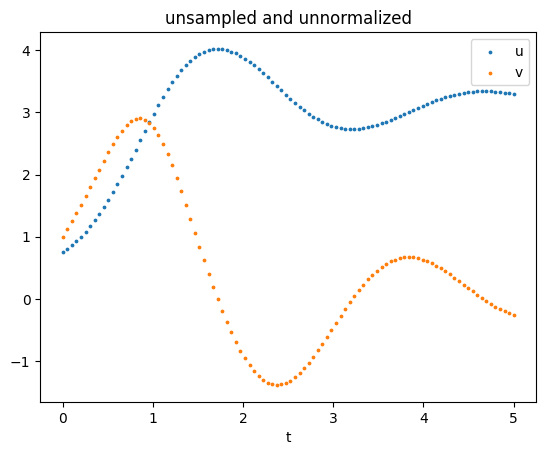

In [5]:
fig, ax = plt.subplots()
ax.scatter(dataset.get_coords().cpu(), dataset.get_data()[:, 0].cpu(), label="u", s=3)
ax.scatter(dataset.get_coords().cpu(), dataset.get_data()[:, 1].cpu(), label="v", s=3)
ax.set_xlabel("t")
ax.legend()
ax.set_title("unsampled and unnormalized")
plt.show()

# Firstly we can use standardization 
We can add standardization to the coordinates and data by providing this to the preprocess function:

In [6]:
def custom_normalize(feature):
        """minmax all features by their absolute maximum
        Args:
            feature (torch.tensor): data to be minmax normalized
        Returns:
            (torch.tensor): minmaxed data"""
        return (feature/feature.abs().max(axis=0).values)

We can now pass the function that loads the data to the DeePyMoD Dataset module, which loads the data, preprocesses it, subsamples it and then sends it to the right device.

In [7]:
dataset = Dataset(
    create_data,
    preprocess_kwargs={"noise_level": 0,  
        "normalize_coords": True,
        "normalize_data": True,},
    apply_normalize=custom_normalize,
    device=device
)

Dataset is using device:  cpu


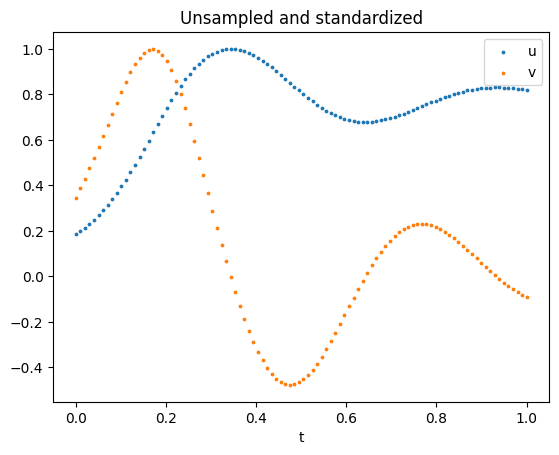

In [8]:
fig, ax = plt.subplots()
ax.scatter(dataset.coords.cpu(), dataset.data[:, 0].cpu(), label="u", s=3)
ax.scatter(dataset.coords.cpu(), dataset.data[:, 1].cpu(), label="v", s=3)
ax.set_xlabel("t")
ax.legend()
ax.set_title("Unsampled and standardized")
plt.show()

In [9]:
dataset.data.shape

torch.Size([100, 2])

We can now do the same, but also randomly subsample the data:

In [10]:
dataset = Dataset(
    create_data,
    subsampler=Subsample_random,
    subsampler_kwargs={"number_of_samples": 100},
    preprocess_kwargs={
        "noise_level": 0.01,
        "normalize_coords": True,
        "normalize_data": True,
    },
    apply_normalize=custom_normalize,
    device=device
)
dataset.data.shape

Dataset is using device:  cpu


torch.Size([100, 2])

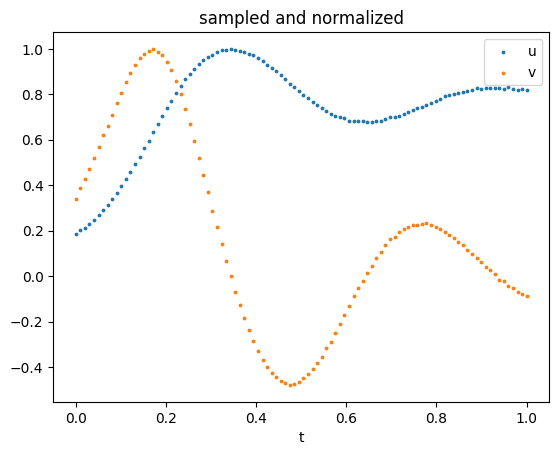

In [11]:
fig, ax = plt.subplots()
ax.scatter(dataset.coords.cpu(), dataset.data[:, 0].cpu(), label="u", s=3)
ax.scatter(dataset.coords.cpu(), dataset.data[:, 1].cpu(), label="v", s=3)
ax.set_xlabel("t")
ax.legend()
ax.set_title("sampled and normalized")
plt.show()

Now we need to split our data into a train and test dataloaders for PyTorch

In [12]:
 # see deepymod.data.base.get_train_test_loader for definition of `get_train_test_loader` function.
 # the shuffle is completely random mixing latter and earlier times
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.8)

In [13]:
for batch_idx, (input, target) in enumerate(train_dataloader):
    print(f"Batch {batch_idx} - Input shape: {input.shape}, Target shape: {target.shape}")


Batch 0 - Input shape: torch.Size([80, 1]), Target shape: torch.Size([80, 2])


In [14]:
for batch_idx, (input, target) in enumerate(test_dataloader):
    print(f"Batch {batch_idx} - Input shape: {input.shape}, Target shape: {target.shape}")


Batch 0 - Input shape: torch.Size([20, 1]), Target shape: torch.Size([20, 2])


# Setup a custom library

In this notebook we show how the user can create a custom build library.The library function, $\theta$, in this case contains $[1,u,v, sin(u)]$ to showcase that non-linear terms can easily be added to the library

In [15]:
from torch.autograd import grad
from itertools import combinations, product
from functools import reduce

In [16]:
class Library_nonlinear(Library):  # see: deepymod.model.deepmod.Library
    """[summary]

    Args:
        Library ([type]): [description]
    """

    def __init__(self) -> None:
        super().__init__()

    def library(
        self, input: Tuple[torch.Tensor, torch.Tensor]
    ) -> Tuple[TensorList, TensorList]:

        prediction, data = input
        samples = prediction.shape[0]
        poly_list = []
        deriv_list = []
        time_deriv_list = []
        # Construct the theta matrix
        C = torch.ones_like(prediction[:, 0]).view(samples, -1) # constant of ones
        u = prediction[:, 0].view(samples, -1) # a term proportional to u
        v = prediction[:, 1].view(samples, -1) # a term proportional to v
        theta = torch.cat((C, u, v, torch.sin(u)), dim=1) # a term porportional to sin(u)
        # Construct a list of time_derivatives
        time_deriv_list = []
        for output in torch.arange(prediction.shape[1]):
            dy = grad(
                prediction[:, output],
                data,
                grad_outputs=torch.ones_like(prediction[:, output]),
                create_graph=True,
            )[0]
            time_deriv = dy[:, 0:1]
            time_deriv_list.append(time_deriv)
        return time_deriv_list, [theta, theta]

## Configuring DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.

In [17]:
network = NN(1, [30, 30, 30, 30], 2)

Configuration of the library function: We select the custom build library we created earlier

In [18]:
library = Library_nonlinear()

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged.

In [19]:
estimator = Threshold(0.5)
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5)

Configuration of the sparsity estimator

In [20]:
constraint = LeastSquares()

Now we instantiate the model and select the optimizer

In [21]:
model = DeepMoD(network, library, estimator, constraint)# .to(device)

In [22]:
model

DeepMoD(
  (func_approx): NN(
    (network): Sequential(
      (0): Linear(in_features=1, out_features=30, bias=True)
      (1): Tanh()
      (2): Linear(in_features=30, out_features=30, bias=True)
      (3): Tanh()
      (4): Linear(in_features=30, out_features=30, bias=True)
      (5): Tanh()
      (6): Linear(in_features=30, out_features=30, bias=True)
      (7): Tanh()
      (8): Linear(in_features=30, out_features=2, bias=True)
    )
  )
  (library): Library_nonlinear()
  (sparse_estimator): Threshold()
  (constraint): LeastSquares()
)

Defining optimizer

In [23]:
optimizer = torch.optim.Adam(
    model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=5e-3
)

## Run DeepMoD

We can now run DeepMoD using all the options we have set and the training data. We need to slightly preprocess the input data for the derivatives:

In [24]:
%%time
train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    # log_dir='runs/coupled/',
    log_dir="./data/deepymod/coupled_new/",
    max_iterations=100000,
    delta=1e-3,
    patience=100,
)

  8275  MSE: 1.35e-01  Reg: 2.86e-03  L1: 2.00e+00 Algorithm converged. Writing model to disk.
CPU times: user 1min 45s, sys: 3.05 s, total: 1min 48s
Wall time: 1min 45s


Now that DeepMoD has converged, it has found the following coefficients to not be zero: 

In [25]:
model.sparsity_masks

[tensor([False, False,  True, False]), tensor([False, False,  True, False])]

In [26]:
model.estimator_coeffs()

[array([[0.        ],
        [0.        ],
        [0.93314254],
        [0.        ]], dtype=float32),
 array([[ 0.       ],
        [ 0.       ],
        [-0.9918309],
        [ 0.       ]], dtype=float32)]

And it found the following coefficients.

In [27]:
model.constraint_coeffs()

[tensor([[0.0000],
         [0.0000],
         [1.1281],
         [0.0000]], grad_fn=<MaskedScatterBackward0>),
 tensor([[ 0.0000],
         [ 0.0000],
         [-3.8314],
         [ 0.0000]], grad_fn=<MaskedScatterBackward0>)]